## Install below libraries using pip commands

1. How to install CLIP

https://github.com/openai/CLIP

2. How to install Taming Transformer

!pip install git+https://github.com/CompVis/taming-transformers


In [1]:
!git clone https://github.com/openai/CLIP.git
!git clone https://github.com/CompVis/taming-transformers

Cloning into 'CLIP'...
remote: Enumerating objects: 236, done.
remote: Total 236 (delta 0), reused 0 (delta 0), pack-reused 236
Receiving objects: 100% (236/236), 8.92 MiB | 16.00 MiB/s, done.
Resolving deltas: 100% (120/120), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1339, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1339 (delta 0), reused 2 (delta 0), pack-reused 1335
Receiving objects: 100% (1339/1339), 409.77 MiB | 28.76 MiB/s, done.
Resolving deltas: 100% (280/280), done.


-------

In [2]:
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.5.10
!pip uninstall torchtext--yes
!pip install einops
!pip install taming-transformers-rom1504

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 527 kB 23.8 MB/s 
     |████████████████████████████████| 512 kB 68.0 MB/s 
     |████████████████████████████████| 829 kB 60.6 MB/s 
     |████████████████████████████████| 952 kB 72.1 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491071 sha256=a9a9cb51937fd54ebfe921b9a0a0934c676a815de99fbc492433ec56145ec3e8
  Stored in directory: /root/.cache/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: future
    Found existing installa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 329 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 284 kB/s 


In [3]:
!curl -L -o model.yaml -C - 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1'
!curl -L -o last.ckpt -C - 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   692  100   692    0     0   3264      0 --:--:-- --:--:-- --:--:--  3264
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  934M  100  934M    0     0  14.8M      0  0:01:02  0:01:02 --:--:-- 14.9M


In [4]:
# import libraries
import numpy as np
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import PIL
import matplotlib.pyplot as plt
import yaml 
from omegaconf import OmegaConf
from CLIP import clip
#import warnings
#warnings.filterwarnings(‘ignore’)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Helper function

In [5]:
def ShowFromTensor(tensor):
    img = tensor.clone()
    img = img.mul(255).byte()
    img = img.cpu().numpy().transpose((1,2,0))
    plt.figure(figsize=(10,7))
    plt.axis('off')
    plt.imshow(img)
    plt.show()
def NormData(data):
    return (data.clip(-1,1)+1)/2 ### range between 0 and 1 in the result

### Parameters 
learning_rate = .5
batch_size = 1
wd = .1 ## weight decay is regularization parameter, help to limit the size of weight and improve generalization capabilities of the architecture
noise_factor = .22 ## .1, .14 ...
total_iter=100 ## use more no. of iterations for more polished result 
im_shape = [450, 450, 3] # height, width, channel
size1, size2, channels = im_shape
w1 = 1

## CLIP model

In [6]:
# Create CLIP model
clipmodel, _ = clip.load('ViT-B/32', jit=False)
clipmodel.eval()
print(clip.available_models())
print("Clip model visual input resolution: ", clipmodel.visual.input_resolution)
device=torch.device("cuda:0")
torch.cuda.empty_cache()

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 118MiB/s]


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip model visual input resolution:  224


## These models below are downloaded

In [7]:
from taming.models.vqgan import VQModel

def LoadConfig(config_path, display=False):
    config_data = OmegaConf.load(config_path)
    if display:
        print(yaml.dump(OmegaConf.to_container(config_data)))
    return config_data
def LoadVQGAN(config, chk_path=None):
    model = VQModel(**config.model.params)
    if chk_path is not None:
        state_dict = torch.load(chk_path, map_location="cpu")["state_dict"]
        missing, unexpected = model.load_state_dict(state_dict, strict=False)
    return model.eval()

def Generator(x):
    x = taming_model.post_quant_conv(x)
    x = taming_model.decoder(x)
    return x

taming_config=LoadConfig("model.yaml", display=True)
taming_model=LoadVQGAN(taming_config,chk_path="last.ckpt").to(device)

model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 94.1kB/s]                   


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [8]:
class Parameters(torch.nn.Module):
    def __init__(self):
        super(Parameters, self).__init__()
        self.data = .5*torch.randn(batch_size, 256, size1//16, size2//16).cuda() # 1x256x28.125x28.125 (450/16, 450/16)
        self.data = torch.nn.Parameter(torch.sin(self.data))
    def forward(self):
        return self.data
    
def init_params():
    params=Parameters().cuda()
    optimizer = torch.optim.AdamW([{'params':[params.data], 'lr':learning_rate}], weight_decay=wd)
    return params, optimizer

## Encoding of text prompts in CLIP architecture:

torch.Size([1, 256, 28, 28])
img dimensions:  torch.Size([1, 3, 448, 448])


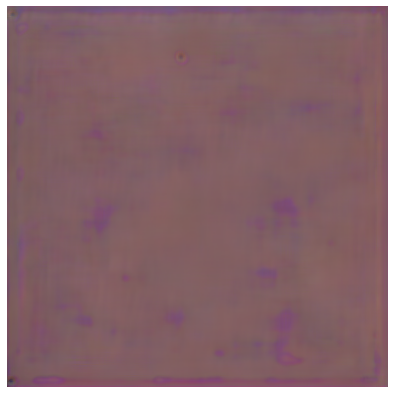

In [9]:
# Let’s Encode prompts
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
def encodeText(text):
    t=clip.tokenize(text).cuda()
    t=clipmodel.encode_text(t).detach().clone()
    return t

exclude_enc=encodeText('watermark, cropped, confusing, blurry')
extras_enc=0

def createEncodings(include, exclude, extras):
    include_enc=[]
    for text in include:
        include_enc.append(encodeText(text))
    exclude_enc=encodeText(exclude) if exclude != '' else 0
    extras_enc=encodeText(extras) if extras !='' else 0
    return include_enc, exclude_enc, extras_enc


augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2, .2), fill=0)).cuda()

Params, optimizer = init_params()

with torch.no_grad():
    print(Params().shape)
    img= NormData(Generator(Params()).cpu()) # 1 x 3 x 450 x 450 [450 x 450]
    print("img dimensions: ",img.shape)
    ShowFromTensor(img[0])

## Create crops:

In [10]:
def createCrops(img, num_crops=32):
    p = size1//2
    # 1 x 3 x 672 x 672 (adding 112*2 on all sides to 448x448)
    img = torch.nn.functional.pad(img, (p, p, p, p), mode='constant', value=0)

    img = augTransform(img)  # RandomHorizontalFlip and RandomAffine
    crop_set = []
    for ch in range(num_crops):
        gap1 = int(torch.normal(1.2, .3, ()).clip(.43, 1.9) * size1)
        offsetx = torch.randint(0, int(size1*2-gap1), ())
        offsety = torch.randint(0, int(size1*2-gap1), ())
        crop = img[:, :, offsetx:offsetx+gap1, offsety:offsety+gap1]
        crop = torch.nn.functional.interpolate(crop, (224, 224), mode='bilinear', align_corners=True)
        crop_set.append(crop)
    img_crops = torch.cat(crop_set, 0)  # 30 x 3 x 224 x 224
    randnormal = torch.randn_like(img_crops, requires_grad=False)
    num_rands = 0
    randstotal = torch.rand((img_crops.shape[0], 1, 1, 1)).cuda()  # 32

    for ns in range(num_rands):
        randstotal *= torch.rand((img_crops.shape[0], 1, 1, 1)).cuda()
        img_crops = img_crops + noise_factor*randstotal*randnormal
    return img_crops

In [11]:
def showMe(Params, show_crop):
    with torch.no_grad():
        generated = Generator(Params())
    if (show_crop):
        print("Augmented cropped example")
        aug_gen = generated.float()  # 1 x 3 x 224 x 400
        aug_gen = createCrops(aug_gen, num_crops=1)
        aug_gen_norm = NormData(aug_gen[0])
        ShowFromTensor(aug_gen_norm)
    print("Generation")
    latest_gen = NormData(generated.cpu())  # 1 x 3 x 224 x 400
    ShowFromTensor(latest_gen[0])
    return (latest_gen[0])

In [12]:
# Optimization process
def optimizeResult(Params, prompt):
    alpha = 1  # the importance of the include encodings
    beta = .5  # the importance of the exclude encodings
# image encoding
    out = Generator(Params())
    out = NormData(out)
    out = createCrops(out)
    out = normalize(out)  # 32 x 3 x 448 x 448
    image_enc = clipmodel.encode_image(out)  # 32 x 512
# text encoding  w1 and w2
    final_enc = w1*prompt+w1*extras_enc  # prompt and extras_enc:1x512
    final_text_include_enc = final_enc / \
        final_enc.norm(dim=-1, keepdim=True)  # 1x512
    final_text_exclude_enc = exclude_enc
# calculate the loss
    main_loss = torch.cosine_similarity(
        final_text_include_enc, image_enc, -1)  # 32
    penalize_loss = torch.cosine_similarity(
        final_text_exclude_enc, image_enc, -1)  # 32
    final_loss = -alpha*main_loss + beta*penalize_loss
    return final_loss


def Optimize(Params, optimizer, prompt):
    loss = optimizeResult(Params, prompt).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [13]:
# training loop
def training_loop(Params, optimizer, text, total_iter, show_crop=False):
    res_img = []
    res_z = []
    show_step = 100
    include=[text]
    exclude='watermark, cropped, confusing, blurry'
    extras = "watercolor paper"
    
    include_enc, _, _ = createEncodings(include, exclude, extras)
    for prompt in include_enc:
        iteration = 0
        Params, optimizer = init_params()  # 1 x 256 x 14 x 25 (225/16, 400/16)
        for it in range(total_iter):
            loss = Optimize(Params, optimizer, prompt)
            if iteration >= 80 and iteration % show_step == 0:
                new_img = showMe(Params, show_crop)
                res_img.append(new_img)
                res_z.append(Params())  # 1 x 256 x 14 x 25
                print("loss:", loss.item(), "\nno. of iteration:", iteration)
            iteration += 1
            torch.cuda.empty_cache()
    return res_img, res_z

In [14]:
def myfunc(text):
    torch.cuda.empty_cache()
    w1=1
    w2=1
    noise_factor= .28
    total_iter=400

    res_img, res_z= training_loop(Params, optimizer, text, total_iter, show_crop=True)
    return res_img

In [15]:
import torchvision.transforms as T

In [16]:
# finalImg = T.ToPILImage()(res_img[-1])
# finalImg.save("Image.jpg")

In [17]:
!pip install flask_ngrok
!pip install flask-cors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
# cowimage = myfunc('cow eating grass')

In [19]:
# finalImg = T.ToPILImage()(cowimage[-1])
# finalImg.save("Image.jpg")

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://5679-35-204-175-232.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
JSON {'text': 'Iron Man Flying'}
TEXT Iron Man Flying
FN c29e1423-350b-4eb7-bfbd-200b894664ea
Augmented cropped example


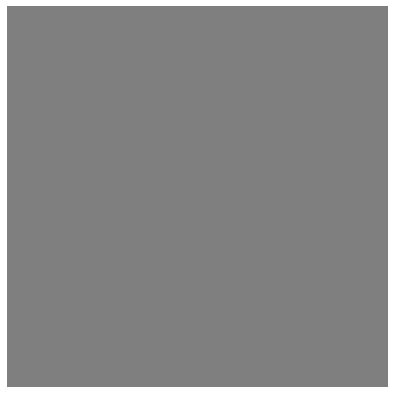

Generation


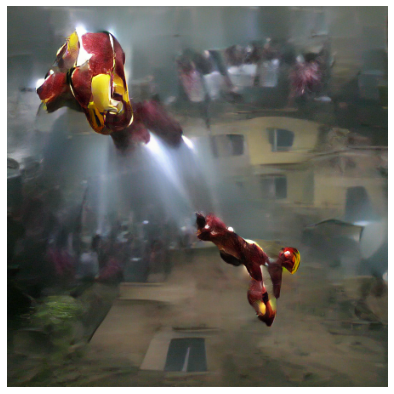

loss: -0.269775390625 
no. of iteration: 100
Augmented cropped example


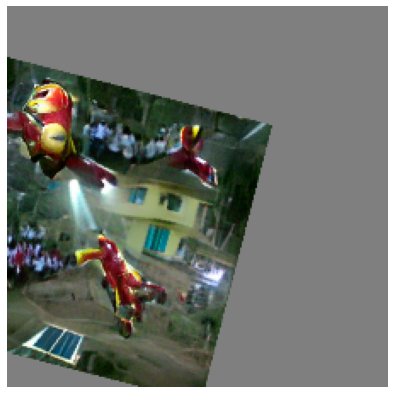

Generation


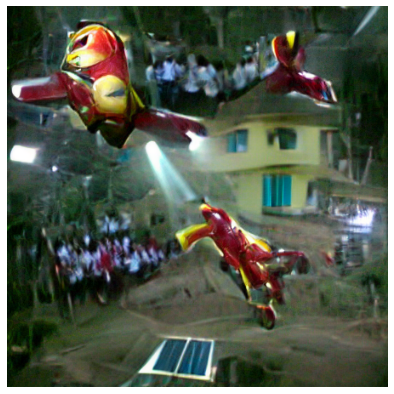

loss: -0.306884765625 
no. of iteration: 200
Augmented cropped example


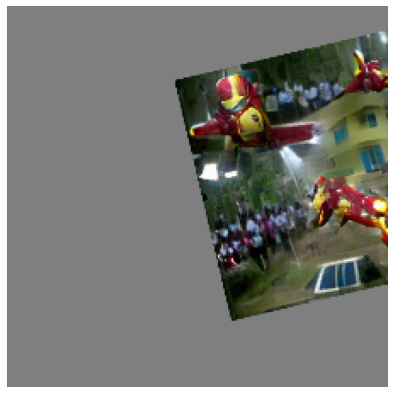

Generation


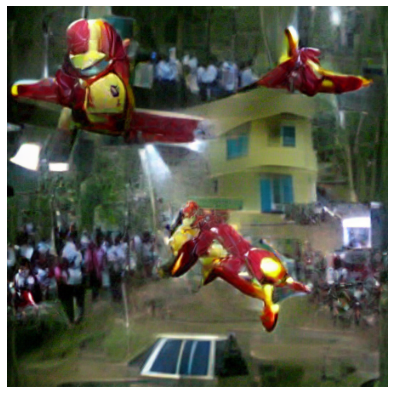

loss: -0.301513671875 
no. of iteration: 300


INFO:werkzeug:127.0.0.1 - - [23/Dec/2022 04:01:26] "POST /prediction HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Dec/2022 04:01:28] "GET /api/c29e1423-350b-4eb7-bfbd-200b894664ea.jpg HTTP/1.1" 200 -


In [20]:
import pandas as pd
from flask_ngrok import run_with_ngrok
from flask_cors import CORS
from flask import request, jsonify, Flask
import random as rk
import traceback
import uuid

application = Flask(__name__, static_url_path='/api', static_folder='')
CORS(application)
run_with_ngrok(application)
  
@application.route('/prediction', methods=['POST'])
#define function
def predict():
      filename = str(uuid.uuid4())
      json_ = request.json
      print("JSON", json_)
      print("TEXT", json_['text'])
      print("FN", filename)
      myImage = myfunc(json_['text'])
      finalImg = T.ToPILImage()(myImage[-1])
      finalImg.save(filename + ".jpg")
      return jsonify({
          # 'input': inp,
          'filename': filename,
          # 'prediction': str(predict), 
      # 'image': encoded_string.decode('utf-8')
      })

application.run()